In [2]:
import scipy.io
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import kurtosis, skew

from rcv_distribution import *
from rcv_dimensionality import *
from voting_rules import *
import itertools
import itertools
import random
import math

In [3]:
def pefrom_MDS(file):

    ballots, candidates = parse_election_data(file)
    '''list_freq = frequency(ballots, candidates)
    ignore_values = ['(WRITE-IN)', 'WRITE-IN', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote', 'Undeclared', 'undervote', 'Write in']
    if ignore:
        for (candidate, freq) in list_freq:
            if freq < 4:
                print("ignored: ", candidate, ": ", freq)
                ignore_values.append(candidate)

        ballots, candidates = parse_election_data(file, ignore_values=ignore_values)'''

    print("running MDS: ")
    test = perform_rcv_analysis(file, n_runs=1000)
    mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

    normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
    
    return normalized_distances

In [4]:
# Load data from a .mat file
mat_data = scipy.io.loadmat('data/Maine_11062018_CongressionalDistrict2.mat')
data_list = []
for i in range(len(mat_data['my_data'])):
    data_list.append(mat_data['my_data'][i][0])



In [5]:
normalized_distance = pefrom_MDS('dataverse_files/Maine_11062018_CongressionalDistrict2.csv')


running MDS: 


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\team_arrow\clean\rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


In [6]:
print(normalized_distance)
print(list(normalized_distance.values()))

{'DEM Golden, Jared F.': 0.0, 'Bond, Tiffany L.': 0.9459271114896624, 'Hoar, William R.S.': 1.733120651865034, 'REP Poliquin, Bruce': 3.0}
[0.0, 0.9459271114896624, 1.733120651865034, 3.0]


In [7]:

def sample_from_data(data, size):
    kde = gaussian_kde(data)
    samples = kde.resample(size=math.floor(size))
    return samples


In [19]:
def generate_ballots(gamma, voters, normalized, V):
    ballots = {}
    normalized_names = []
    normalized_points = []
    reverse_dict = {}
    for candidate in normalized:
        reverse_dict[normalized[candidate]] = candidate
        normalized_names.append(candidate)
        normalized_points.append(normalized[candidate])
    bullets = 0
    for position in voters[0]:
        ranking = ()
        bullet = False
        for candidate in normalized_points:
           # print("p : ", position, " c: ", candidate)
            if abs(position - candidate) <= 0.2:
                ranking += (reverse_dict[candidate],)
                #print("a bullet vote: candidate: ", candidate, " position: ", position, " ranking: ", ranking)
                if ranking not in ballots:
                    ballots[ranking] = 1
                else:
                    ballots[ranking] += 1
                bullet = True
                bullets += 1
        if bullet is not True:
            sorted_list = sorted(normalized_points, key=lambda x: abs(x - position))
            for c in sorted_list:
                ranking += (reverse_dict[c],)
            if ranking not in ballots:
                ballots[ranking] = 1
                #print(ranking)
            else:
                ballots[ranking] += 1

    all_combinations = list(itertools.permutations(normalized_names))
    #random_combinations = random.choices(all_combinations, k=math.floor((1 - gamma) * V))
    #print("random: ", random_combinations)
    i = 0
    while i < (1-gamma)*V:
        ranking = ()
        random_combination = random.choice(all_combinations)
        b_num = []
        for c in random_combination:
            ranking += (c,)
            b_num.append(normalized_distance[c])
        
        if (evaluate_ballot_consistency(b_num, len(normalized))[0] is False):
            if ranking not in ballots:
                ballots[ranking] = 1
            else:
                ballots[ranking] += 1
            i += 1
        
    print(bullets)
    return ballots

            
            
            

In [9]:

def get_intervals(normalized_distances, ballots, candidates):

    n = len(candidates)
    #print("getting intervals: ")
    normalized_names = []
    normalized_points = []
    for candidate in normalized_distances:
        normalized_names.append(candidate)
        normalized_points.append(normalized_distances[candidate])
    temp = {}
    i = 0
    for candidate in normalized_distances:
        temp[candidate] = i
        i += 1
    non_bullet = {}
    bullet = {}
    for ballot in ballots:
        if len(ballot) == 0:
            continue
        ballot_num = []
        for candidate in ballot:
            ballot_num.append(temp[candidate])
        
        consistency = evaluate_ballot_consistency(ballot_num, len(candidates))
        if consistency[0] is True:
            point = consistency[1]
            first_place = ballot[0]
            i = normalized_names.index(first_place)
            #print(normalized_distances[first_place])
            if len(ballot) == 1:
                if normalized_distances[ballot[0]] not in bullet:
                    bullet[normalized_distances[ballot[0]]] = 0
                bullet[normalized_distances[ballot[0]]] += ballots[ballot]

            elif normalized_distances[first_place] == 0:
                i = normalized_names.index(first_place)
                center = normalized_distances[first_place] + (normalized_distances[normalized_names[i + 1]] - normalized_distances[first_place])/4
                width = (normalized_distances[normalized_names[i + 1]] - normalized_distances[first_place])/2
            elif normalized_distances[first_place] == n - 1:
                i = normalized_names.index(first_place)
                center = normalized_distances[first_place] - (normalized_distances[first_place] - normalized_distances[normalized_names[i - 1]])/4
                width = (normalized_distances[first_place] - normalized_distances[normalized_names[i - 1]])/2
                
            else:
                if point < normalized_distances[first_place]:
                    i = normalized_names.index(first_place)
                    center = normalized_distances[first_place] - (normalized_distances[first_place] - normalized_distances[normalized_names[i - 1]])/4
                    width = (normalized_distances[first_place] - normalized_distances[normalized_names[i - 1]])/2
                else:
                    i = normalized_names.index(first_place)
                    #print(normalized_names)
                    #print(i)
                    #print(ballot)
                    center = normalized_distances[first_place] + (normalized_distances[normalized_names[i + 1]] - normalized_distances[first_place])/4
                    width = (normalized_distances[normalized_names[i + 1]] - normalized_distances[first_place])/2
            
            if len(ballot) > 1:
                if (center, width) not in non_bullet:
                    non_bullet[(center, width)] = 0
                non_bullet[(center, width)] += ballots[ballot]
            
    points = {}

    for t in non_bullet:
 
        if t[0] not in points:
            points[t[0]] = 0
        points[t[0]] += non_bullet[t]

    for p in bullet:
        if p not in points:
            points[p] = 0
        points[p] += bullet[p]
    
    data = []
    for t in non_bullet:
        center = t[0]
        width = t[1]
        low = center - (width/2)
        high = center + (width/2)
        y = non_bullet[t]
        sample_size = y
        chunk_size = width/y
        for i in range(y):
            data.append(low+(i*chunk_size))
    for p in bullet:
        center = p
        width = 0.2
        low = center - (width/2)
        high = center + (width/2)
        y = bullet[p]
        sample_size = y
        chunk_size = width/y
        for i in range(y):
            data.append(low+(i*chunk_size))
    
    return data

In [10]:
ballots, candidates = parse_election_data('dataverse_files/Maine_11062018_CongressionalDistrict2.csv')
d = get_intervals(normalized_distance, ballots, candidates)

In [11]:
def simulator(gamma, voters, normalized, V, C):
    sample_consistent = sample_from_data(voters, gamma*V)
    '''sample_candidates = sample_from_data(candidates, C)
    sample_candidates = sorted(sample_candidates)'''
    ballots = generate_ballots(gamma, sample_consistent, normalized, V)
    #print(ballots)
    return ballots
    



In [21]:
ballots = simulator(0.8, data_list, normalized_distance, 199000, 4)
#print(ballots)
total = 0
consistent = 0
for b in ballots:
    #print(b)
    b_num = []
    for c in b:
        b_num.append(normalized_distance[c])
    total += ballots[b]
    if (evaluate_ballot_consistency(b_num, 4)[0] is True):
        consistent += ballots[b]
gamma = consistent/total
print(gamma)

109467
0.7967386934673367


In [22]:
data = get_intervals(normalized_distance, ballots, normalized_distance.values())

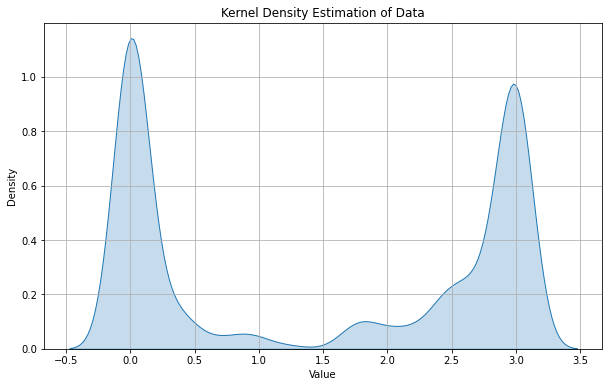

In [23]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data, fill=True)
plt.title('Kernel Density Estimation of Data')
#plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

5496
0.7961


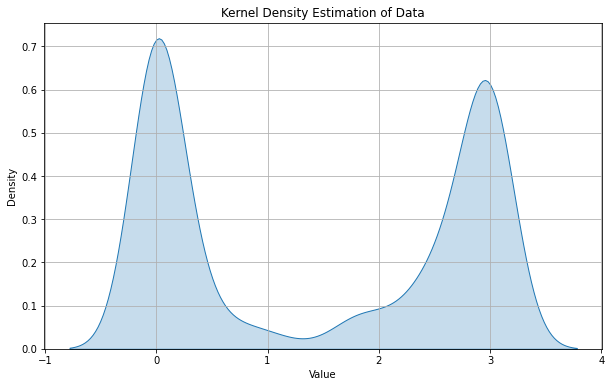

In [24]:
ballots = simulator(0.8, data_list, normalized_distance, 10000, 4)
total = 0
consistent = 0
for b in ballots:
    b_num = []
    for c in b:
        b_num.append(normalized_distance[c])
    total += ballots[b]
    if (evaluate_ballot_consistency(b_num, 4)[0] is True):
        consistent += ballots[b]
gamma = consistent/total
print(gamma)
data = get_intervals(normalized_distance, ballots, normalized_distance.values())
plt.figure(figsize=(10, 6))
sns.kdeplot(data, fill=True)
plt.title('Kernel Density Estimation of Data')
#plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

110284
0.79672


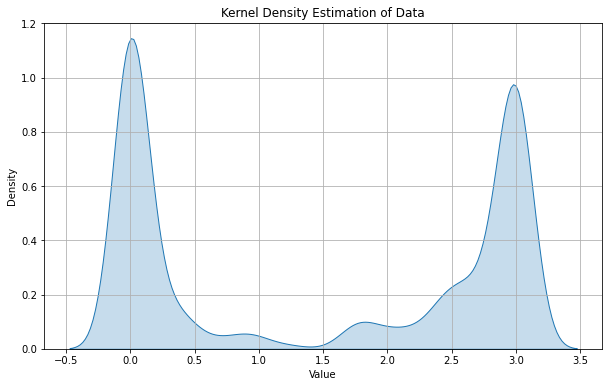

In [25]:
ballots = simulator(0.8, data_list, normalized_distance, 200000, 4)
total = 0
consistent = 0
for b in ballots:
    b_num = []
    for c in b:
        b_num.append(normalized_distance[c])
    total += ballots[b]
    if (evaluate_ballot_consistency(b_num, 4)[0] is True):
        consistent += ballots[b]
gamma = consistent/total
print(gamma)
data = get_intervals(normalized_distance, ballots, normalized_distance.values())
plt.figure(figsize=(10, 6))
sns.kdeplot(data, fill=True)
plt.title('Kernel Density Estimation of Data')
#plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

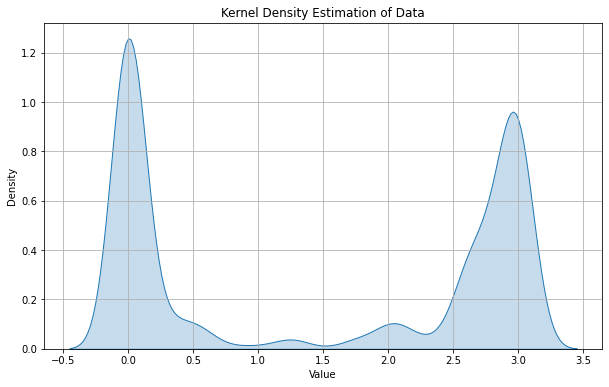

In [92]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
#plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()